<a href="https://colab.research.google.com/github/YairFrank/transfermarkt/blob/main/feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Import data
data = pd.read_csv('Covid Data.csv')
data.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,2,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,2,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,2,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,2,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,2,2,2,1,2,2,2,2,2,3,97


In [ ]:
data.shape

(1048575, 21)

In [ ]:
# Find features having 0, 1 or too many unique values
data.nunique().sort_values()

USMER                     2
SEX                       2
PATIENT_TYPE              2
TOBACCO                   3
RENAL_CHRONIC             3
OBESITY                   3
CARDIOVASCULAR            3
OTHER_DISEASE             3
HIPERTENSION              3
INMSUPR                   3
ASTHMA                    3
COPD                      3
DIABETES                  3
PNEUMONIA                 3
PREGNANT                  4
INTUBED                   4
ICU                       4
CLASIFFICATION_FINAL      7
MEDICAL_UNIT             13
AGE                     121
DATE_DIED               401
dtype: int64

In [ ]:
# Find features having too many Null values
data.isna().sum().sort_values(ascending=False)

Diabetes_binary         0
HighBP                  0
Education               0
Age                     0
Sex                     0
DiffWalk                0
PhysHlth                0
MentHlth                0
GenHlth                 0
NoDocbcCost             0
AnyHealthcare           0
HvyAlcoholConsump       0
Veggies                 0
Fruits                  0
PhysActivity            0
HeartDiseaseorAttack    0
Stroke                  0
Smoker                  0
BMI                     0
CholCheck               0
HighChol                0
Income                  0
dtype: int64

In [ ]:
import numpy as np

# # Data preparation for feature selection

# # Remove columns from the list that are not relevant (based on the 2 analyzes above)
# data_for_feat_sel = data.drop(['Unnamed: 0','v_start','install','os','frameworkid','playable','country',
#                                'type','ldatopics','deviceid','segmentids','pmmlprobability','usercategoryweeklycounters',
#                                'bidtime','bidid','time','bundlenativedailyfc','bundlenativetotalfc',
#                                'bundlebannerdailyfc','bundlebannertotalfc','imprprice','gender','creativetype'], axis=1)

# data_for_feat_sel = data_for_feat_sel.dropna(axis=1, how='all')

# # Remove the hot-encoded features
# data_for_feat_sel = data_for_feat_sel[data_for_feat_sel.columns.drop(list(data_for_feat_sel.filter(regex='topic')))]

# # Remove all rows having Null values
# data_for_feat_sel = data_for_feat_sel.dropna()
data_for_feat_sel = data
# Create correlation matrix
corr_matrix = data_for_feat_sel.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(to_drop)

# Drop features
data_for_feat_sel.drop(to_drop, axis=1, inplace=True)

data_for_feat_sel.head()

<ipython-input-24-17d039ec2400>:20: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data_for_feat_sel.corr().abs()


['INTUBED', 'PREGNANT', 'ICU']


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,PNEUMONIA,AGE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL
0,2,1,1,1,03/05/2020,1,65,2,2,2,2,1,2,2,2,2,2,3
1,2,1,2,1,03/06/2020,1,72,2,2,2,2,1,2,2,1,1,2,5
2,2,1,2,2,09/06/2020,2,55,1,2,2,2,2,2,2,2,2,2,3
3,2,1,1,1,12/06/2020,2,53,2,2,2,2,2,2,2,2,2,2,7
4,2,1,2,1,21/06/2020,2,68,1,2,2,2,1,2,2,2,2,2,3


In [ ]:
### Feature Importance for both Categorical & Numerical Features (using Random Forests)

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split

# Utilize a Column Transfomer to transform our data into a machine learning acceptable format
column_trans = ColumnTransformer(transformers=
        [('num', MinMaxScaler(), selector(dtype_exclude="object")),
        ('cat', OrdinalEncoder(), selector(dtype_include="object"))],
        remainder='drop')

# Create a random forest classifier for feature importance
clf = RandomForestClassifier(random_state=42, n_jobs=6, class_weight='balanced')

pipeline = Pipeline([('prep',column_trans),
                     ('clf', clf)])

X = data_for_feat_sel.drop(['CLASIFFICATION_FINAL','DATE_DIED'], axis=1)
y = data_for_feat_sel['CLASIFFICATION_FINAL']

# Split the data into 30% test and 70% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4beeeac4f0>),
                                                 ('cat', OrdinalEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4beeeac730>)])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=6,
                                        random_state=42))])

In [ ]:
pipeline['clf'].feature_importances_

array([0.03384303, 0.17747577, 0.03002846, 0.0849699 , 0.05560007,
       0.43877842, 0.02672382, 0.01212491, 0.01278307, 0.01069104,
       0.02527729, 0.01547793, 0.01414451, 0.02738747, 0.01386634,
       0.02082795])

In [ ]:
feat_list = []

total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(X.columns, pipeline['clf'].feature_importances_):
    feat_list.append(feature)
    total_importance += feature[1]

print('\n',"Cumulative Importance =", total_importance)

# Create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['CUMSUM'] = df_imp['IMPORTANCE'].cumsum()
df_imp


 Cumulative Importance = 1.0000000000000004


,FEATURE,IMPORTANCE,CUMSUM
5,AGE,0.438778,0.438778
1,MEDICAL_UNIT,0.177476,0.616254
3,PATIENT_TYPE,0.084970,0.701224
4,PNEUMONIA,0.055600,0.756824
0,USMER,0.033843,0.790667
2,SEX,0.030028,0.820696
13,OBESITY,0.027387,0.848083
6,DIABETES,0.026724,0.874807
10,HIPERTENSION,0.025277,0.900084
15,TOBACCO,0.020828,0.920912


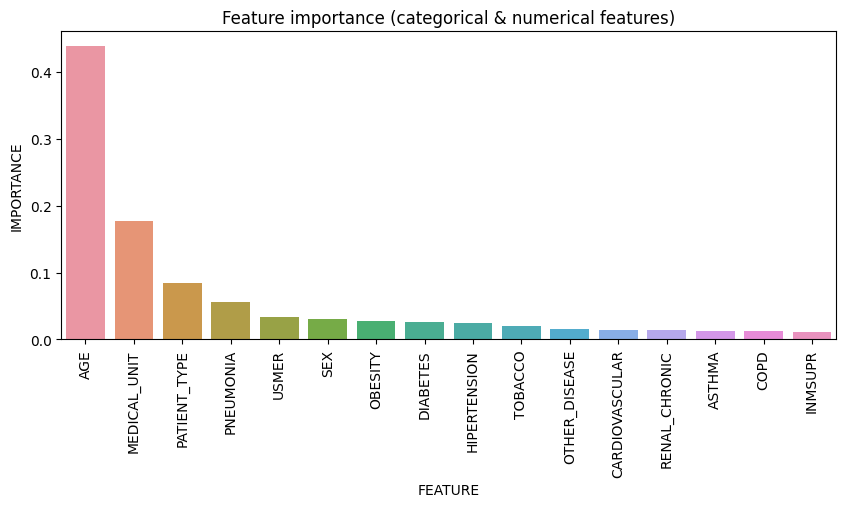

In [ ]:
# Plot the scores
plt.figure(figsize=(10,4))
sns.barplot(x=df_imp['FEATURE'], y=df_imp['IMPORTANCE'])
plt.xticks(rotation = 90)
plt.title('Feature importance (categorical & numerical features)')
plt.show()